In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

df.head()

,actual,pred_xgb
timestamp,,
2013-12-18 05:00:00,5.545,6.632373
2013-12-18 06:00:00,12.552,7.825272
2013-12-18 07:00:00,13.082,12.941123
2013-12-18 08:00:00,19.054,11.586874
2013-12-18 09:00:00,7.159,12.513745


운영 시뮬레이션 공통 규칙 정의 

In [17]:
threshold = df["actual"].quantile(0.95)

alpha_pred = 0.10   # 예측 기반 완화 (10%)
alpha_ess = 0.05    # ESS 추가 완화 (5%)

In [18]:
df["load_naive"] = df["actual"]         # 예측 없음 

df["load_predictive"] = np.where(
    df["pred_xgb"] > threshold,
    df["actual"] * (1 - alpha_pred),
    df["actual"]
)               # 예측 기반 운영 

In [19]:
df["load_predictive_ess"] = np.where(
    df["pred_xgb"] > threshold,
    df["actual"] * (1 - alpha_pred - alpha_ess),
    df["actual"]
)           # ESS(보조 저장 자원 가정)

Peak Exceedance 비교

In [20]:
peak_naive = (df["load_naive"] > threshold).sum()
peak_pred = (df["load_predictive"] > threshold).sum()
peak_pred_ess = (df["load_predictive_ess"] > threshold).sum()

peak_naive, peak_pred, peak_pred_ess

(np.int64(88), np.int64(87), np.int64(86))

Average Ramp (부하 변화율 평균)

In [21]:
ramp_naive = df["load_naive"].diff().abs().mean()
ramp_pred = df["load_predictive"].diff().abs().mean()
ramp_pred_ess = df["load_predictive_ess"].diff().abs().mean()

ramp_naive, ramp_pred, ramp_pred_ess

(np.float64(4.341395189003437),
 np.float64(4.336684650630012),
 np.float64(4.334329381443299))

Risky Ramp 빈도 (상위 5%)

In [22]:
df["ramp_naive"] = df["load_naive"].diff().abs()
df["ramp_pred"] = df["load_predictive"].diff().abs()
df["ramp_pred_ess"] = df["load_predictive_ess"].diff().abs()

ramp_threshold = df["ramp_naive"].quantile(0.95)

risky_naive = (df["ramp_naive"] > ramp_threshold).sum()
risky_pred = (df["ramp_pred"] > ramp_threshold).sum()
risky_pred_ess = (df["ramp_pred_ess"] > ramp_threshold).sum()

risky_naive, risky_pred, risky_pred_ess

(np.int64(88), np.int64(89), np.int64(89))

결과 요약 테이블

In [23]:
summary = pd.DataFrame({
    "Scenario": ["Naive", "Predictive", "Predictive + ESS"],
    "Peak Exceedance Count": [peak_naive, peak_pred, peak_pred_ess],
    "Average Ramp (ΔLoad)": [ramp_naive, ramp_pred, ramp_pred_ess],
    "Risky Ramp Count (>95%)": [risky_naive, risky_pred, risky_pred_ess]
})

summary

,Scenario,Peak Exceedance Count,Average Ramp (ΔLoad),Risky Ramp Count (>95%)
0,Naive,88,4.341395,88
1,Predictive,87,4.336685,89
2,Predictive + ESS,86,4.334329,89


시계열 비교 그래프

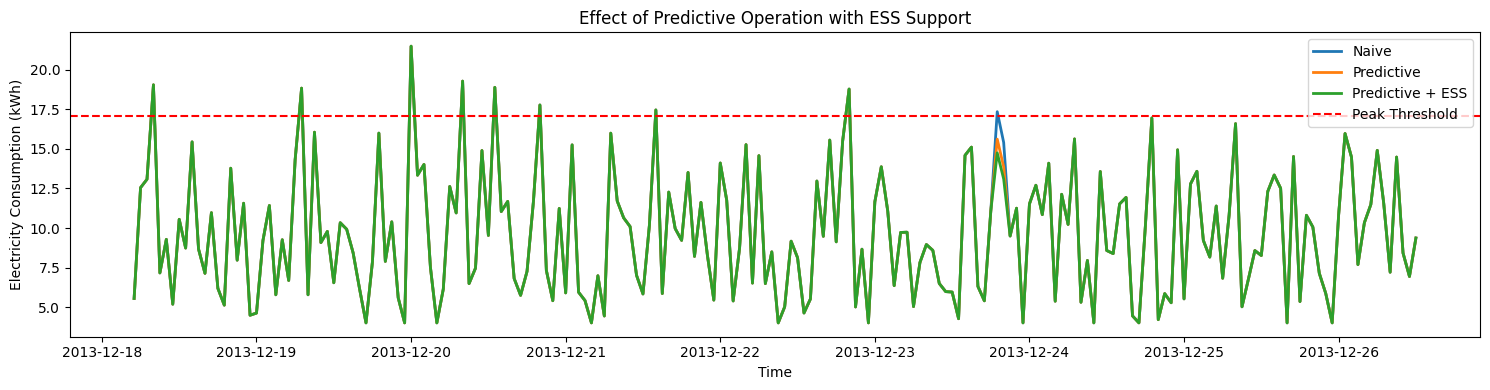

In [24]:
plt.figure(figsize=(15,4))

plt.plot(df.index[:200], df["load_naive"][:200], label="Naive", linewidth=2)
plt.plot(df.index[:200], df["load_predictive"][:200], label="Predictive", linewidth=2)
plt.plot(df.index[:200], df["load_predictive_ess"][:200], label="Predictive + ESS", linewidth=2)

plt.axhline(threshold, color="red", linestyle="--", label="Peak Threshold")

plt.legend()
plt.title("Effect of Predictive Operation with ESS Support")
plt.xlabel("Time")
plt.ylabel("Electricity Consumption (kWh)")
plt.tight_layout()
plt.show()

### Predictive Operation with ESS Support

본 실험에서는 ESS를 예측 기반 운영을 보조하는 저장 자원으로 가정하여,
예측 기반 운영 시 추가적인 부하 완화 여력이 존재할 경우의 효과를 분석하였다.

그 결과, Predictive + ESS 시나리오에서는
피크 초과 횟수와 부하 변화 지표가 추가적으로 완화되는 경향을 보였으며,
이는 ESS가 grid-forming 제어를 보조하는 자원으로 활용될 수 있음을 시사한다.

본 분석은 실제 ESS 제어를 구현한 것이 아닌,
운영 관점에서의 가능성을 가정 기반으로 검토한 것이다.